# Imports

In [1]:
import gymnasium as gym
import random
import torch
import torchrl
from torchvision import transforms as T
from tensordict import TensorDict
from PIL import Image
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
from pathlib import Path



In [2]:
import torch
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### Creating a gym environment

In [3]:
env = gym.make("ALE/SpaceInvaders-v5")
height, width, channels = env.observation_space.shape
actions = env.action_space.n

env.reset()
next_state, reward, done, trunc, info = env.step(0)
print(next_state.shape, reward, done, info)
print(env.unwrapped.get_action_meanings())

(210, 160, 3) 0.0 False {'lives': 3, 'episode_frame_number': 4, 'frame_number': 4}
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


### Preprocessing

##### Skip Frame
Every time we take an action, we repeat it for a certain number of frames. This emulates human input, where a person can not play frame-perfect

In [4]:
class SkipFrame(gym.Wrapper):
    """
    Skips frames for every action. Returns the sum of the rewards for the skipped frames.
    
    :param env: (gym.Env) The environment
    :param skip: (int) The number of frames to skip
    """
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip
    
    def step(self, action):
        """
        Repeat action, and sum reward
        
        :param action: (int) The action
        :return: (tuple) The new observation, the sum of the rewards, the done flag, and additional information
        """
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info
    


##### GrayScaleObeservation

In [5]:
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

##### ResizeObservation

In [6]:
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


In [7]:
env = SkipFrame(env, skip=2)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)

num_stacks = 2

env = gym.wrappers.FrameStack(env, num_stack=num_stacks)

In [8]:
# TODO: Figure out online/training models, hyperparams

class ZeroGameAgent:
    def __init__(self, state_space, action_space, save_dir = None):

        self.action_space = action_space
        self.state_space = state_space
        self.save_dir = save_dir
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.net = ZeroGameNet(self.state_space, self.action_space).float().to(self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5

        
        self.memory = torchrl.data.TensorDictReplayBuffer(storage=torchrl.data.LazyMemmapStorage(100000, device=self.device))
        self.batch_size = 32
        self.gamma = 0.9

        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  


        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()
    
    def act(self, state):
        # Exploration
        if random.random() < self.exploration_rate:
            action = random.randint(0, self.action_space-1)
        # Exploitation
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action = torch.argmax(action_values, axis=1).item()
        
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        self.curr_step += 1
        return action
    
    
    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
    
    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())
    
    def save(self):
        save_path = (
            self.save_dir / f"test_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"TestNet saved to {save_path} at step {self.curr_step}")
    
    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)




In [9]:
class ZeroGameNet(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input height: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim) 
        self.target.load_state_dict(self.online.state_dict())

        for p in self.target.parameters():
            p.requires_grad = False
        
    
    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)
    
    def __build_cnn(self, c, output_dim):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(3136, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, output_dim),
        )

In [10]:
class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))


In [11]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)
zg = ZeroGameAgent(state_space=(num_stacks, 84, 84), action_space=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

    

Using CUDA: True



Episode 0 - Step 251 - Epsilon 0.9999372519608879 - Mean Reward 195.0 - Mean Length 251.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.862 - Time 2024-03-05T14:42:19
Episode 20 - Step 4850 - Epsilon 0.9987882346295732 - Mean Reward 116.429 - Mean Length 230.952 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 13.519 - Time 2024-03-05T14:42:32
Episode 40 - Step 10086 - Epsilon 0.9974816759961261 - Mean Reward 126.707 - Mean Length 246.0 - Mean Loss 0.016 - Mean Q Value 0.001 - Time Delta 18.361 - Time 2024-03-05T14:42:50
Episode 60 - Step 15382 - Epsilon 0.9961618839870565 - Mean Reward 133.361 - Mean Length 252.164 - Mean Loss 0.174 - Mean Q Value 0.013 - Time Delta 38.065 - Time 2024-03-05T14:43:28
Episode 80 - Step 20688 - Epsilon 0.9948413511197547 - Mean Reward 138.148 - Mean Length 255.407 - Mean Loss 0.26 - Mean Q Value 0.022 - Time Delta 34.939 - Time 2024-03-05T14:44:03
Episode 100 - Step 26025 - Epsilon 0.993514869007192 - Mean Reward 147.4 - Mean Length 257.74 - Mean Loss

KeyboardInterrupt: 

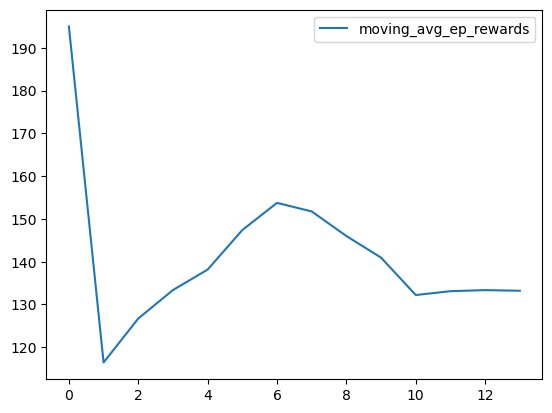

In [12]:
episodes = 8000
for e in range(episodes):
   
    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = zg.act(state)

        # Agent performs action
        try:
            next_state, reward, done, trunc, info = env.step(action)

        except Exception as e:
            print(e)
            print("Error in env.step. Last action:", action)
            break
        # Remember
        zg.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = zg.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done:
            break
        
    logger.log_episode()
    
    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=zg.exploration_rate, step=zg.curr_step)

In [18]:
# tenv = gym.make("ALE/SpaceInvaders-v5", render_mode="human")
# tenv.reset()
# tenv = SkipFrame(tenv, skip=4)
# tenv = GrayScaleObservation(tenv)
# tenv = ResizeObservation(tenv, shape=84)
# tenv = gym.wrappers.FrameStack(tenv, num_stack=num_stacks)

# episodes = 5
# for e in range(episodes):
   
#     state = tenv.reset()

#     # Play the game!
#     while True:

#         # Run agent on the state
#         state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
#         state = torch.tensor(state, device=zg.device).unsqueeze(0)
#         action_values = zg.net(state, model="online")
#         action = torch.argmax(action_values, axis=1).item()

#         # Agent performs action
#         try:
#             next_state, reward, done, trunc, info = tenv.step(action)

#         except Exception as e:
#             print(e)
#             print("Error in env.step. Last action:", action)
#             break
        
#         state = next_state

#         # Check if end of game
#         if done:
#             break


# # saving images

# for i in range(state.shape[0]):
#     img = state[i].cpu().numpy()
#     plt.imshow(img, cmap="gray")
#     plt.savefig(f"state_{i}.png")

# env.env.ale.saveScreenPNG('test_image2.png')



c:\Users\gramp\anaconda3\envs\cuda-env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.ale to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ale` for environment variables or `env.get_wrapper_attr('ale')` that will search the reminding wrappers.
  logger.warn(
